<a href="https://colab.research.google.com/github/NagaHarshita/BTP-ImageInpainting/blob/main/CNN-Inpaint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import cv2
import skimage

from torch.optim.optimizer import Optimizer, required
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter

import pickle as pkl
from PIL import Image

## Models

In [ ]:
def init_weights(net, init_type='normal', gain=0.02):
    from torch.nn import init
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal(m.weight.data, 1.0, gain)
            init.constant(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)


def get_pad(in_,  ksize, stride, atrous=1):
    out_ = np.ceil(float(in_)/stride)
    return int(((out_ - 1) * stride + atrous*(ksize-1) + 1 - in_)/2)

In [ ]:
class GatedConv2dWithActivation(torch.nn.Module):
    """
    Gated Convlution layer with activation (default activation:LeakyReLU)
    Params: same as conv2d
    Input: The feature from last layer "I"
    Output:\phi(f(I))*\sigmoid(g(I))
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True,batch_norm=True, activation=torch.nn.LeakyReLU(0.2, inplace=True)):
        super(GatedConv2dWithActivation, self).__init__()
        self.batch_norm = batch_norm
        self.activation = activation
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.mask_conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.batch_norm2d = torch.nn.BatchNorm2d(out_channels)
        self.sigmoid = torch.nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
    def gated(self, mask):
        #return torch.clamp(mask, -1, 1)
        return self.sigmoid(mask)
    def forward(self, input):
        x = self.conv2d(input)
        mask = self.mask_conv2d(input)
        if self.activation is not None:
            x = self.activation(x) * self.gated(mask)
        else:
            x = x * self.gated(mask)
        if self.batch_norm:
            return self.batch_norm2d(x)
        else:
            return x

In [ ]:
class GatedDeConv2dWithActivation(torch.nn.Module):
    """
    Gated DeConvlution layer with activation (default activation:LeakyReLU)
    resize + conv
    Params: same as conv2d
    Input: The feature from last layer "I"
    Output:\phi(f(I))*\sigmoid(g(I))
    """
    def __init__(self, scale_factor, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, batch_norm=True,activation=torch.nn.LeakyReLU(0.2, inplace=True)):
        super(GatedDeConv2dWithActivation, self).__init__()
        self.conv2d = GatedConv2dWithActivation(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, batch_norm, activation)
        self.scale_factor = scale_factor

    def forward(self, input):
        #print(input.size())
        x = F.interpolate(input, scale_factor=2)
        return self.conv2d(x)

In [ ]:
class SNGatedConv2dWithActivation(torch.nn.Module):
    """
    Gated Convolution with spetral normalization
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, batch_norm=True, activation=torch.nn.LeakyReLU(0.2, inplace=True)):
        super(SNGatedConv2dWithActivation, self).__init__()
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.mask_conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.activation = activation
        self.batch_norm = batch_norm
        self.batch_norm2d = torch.nn.BatchNorm2d(out_channels)
        self.sigmoid = torch.nn.Sigmoid()
        self.conv2d = torch.nn.utils.spectral_norm(self.conv2d)
        self.mask_conv2d = torch.nn.utils.spectral_norm(self.mask_conv2d)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

    def gated(self, mask):
        return self.sigmoid(mask)
        #return torch.clamp(mask, -1, 1)

    def forward(self, input):
        x = self.conv2d(input)
        mask = self.mask_conv2d(input)
        if self.activation is not None:
            x = self.activation(x) * self.gated(mask)
        else:
            x = x * self.gated(mask)
        if self.batch_norm:
            return self.batch_norm2d(x)
        else:
            return x

In [ ]:
class SNGatedDeConv2dWithActivation(torch.nn.Module):
    """
    Gated DeConvlution layer with activation (default activation:LeakyReLU)
    resize + conv
    Params: same as conv2d
    Input: The feature from last layer "I"
    Output:\phi(f(I))*\sigmoid(g(I))
    """
    def __init__(self, scale_factor, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, batch_norm=True, activation=torch.nn.LeakyReLU(0.2, inplace=True)):
        super(SNGatedDeConv2dWithActivation, self).__init__()
        self.conv2d = SNGatedConv2dWithActivation(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, batch_norm, activation)
        self.scale_factor = scale_factor

    def forward(self, input):
        #print(input.size())
        x = F.interpolate(input, scale_factor=2)
        return self.conv2d(x)

In [ ]:
class SNConvWithActivation(torch.nn.Module):
    """
    SN convolution for spetral normalization conv
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, activation=torch.nn.LeakyReLU(0.2, inplace=True)):
        super(SNConvWithActivation, self).__init__()
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.conv2d = torch.nn.utils.spectral_norm(self.conv2d)
        self.activation = activation
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
    def forward(self, input):
        x = self.conv2d(input)
        if self.activation is not None:
            return self.activation(x)
        else:
          x = x * self.gated(mask)
        if self.batch_norm:
            return self.batch_norm2d(x)
        else:
            return x

In [ ]:
class SNGatedDeConv2dWithActivation(torch.nn.Module):
    """
    Gated DeConvlution layer with activation (default activation:LeakyReLU)
    resize + conv
    Params: same as conv2d
    Input: The feature from last layer "I"
    Output:\phi(f(I))*\sigmoid(g(I))
    """
    def __init__(self, scale_factor, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, batch_norm=True, activation=torch.nn.LeakyReLU(0.2, inplace=True)):
        super(SNGatedDeConv2dWithActivation, self).__init__()
        self.conv2d = SNGatedConv2dWithActivation(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, batch_norm, activation)
        self.scale_factor = scale_factor

    def forward(self, input):
        #print(input.size())
        x = F.interpolate(input, scale_factor=2)
        return self.conv2d(x)

In [ ]:
class SNConvWithActivation(torch.nn.Module):
    """
    SN convolution for spetral normalization conv
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, activation=torch.nn.LeakyReLU(0.2, inplace=True)):
        super(SNConvWithActivation, self).__init__()
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.conv2d = torch.nn.utils.spectral_norm(self.conv2d)
        self.activation = activation
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
    def forward(self, input):
        x = self.conv2d(input)
        if self.activation is not None:
            return self.activation(x)
        else:
            return x

In [ ]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [ ]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation,with_attn=False):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        self.with_attn = with_attn
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N)
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)

        out = self.gamma*out + x
        if self.with_attn:
            return out ,attention
        else:
            return out

In [ ]:
class SAGenerator(nn.Module):
    """Generator."""

    def __init__(self, batch_size, image_size=64, z_dim=100, conv_dim=64):
        super(Generator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        repeat_num = int(np.log2(self.imsize)) - 3
        mult = 2 ** repeat_num # 8
        layer1.append(SpectralNorm(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.ReLU())

        curr_dim = conv_dim * mult

        layer2.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.ReLU())

        curr_dim = int(curr_dim / 2)

        layer3.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.ReLU())

        if self.imsize == 64:
            layer4 = []
            curr_dim = int(curr_dim / 2)
            layer4.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
            layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
            layer4.append(nn.ReLU())
            self.l4 = nn.Sequential(*layer4)
            curr_dim = int(curr_dim / 2)

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.ConvTranspose2d(curr_dim, 3, 4, 2, 1))
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn( 128, 'relu')
        self.attn2 = Self_Attn( 64,  'relu')

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z)
        out=self.l2(out)
        out=self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out, p1, p2

In [ ]:
class InpaintSADirciminator(nn.Module):
    def __init__(self):
        super(InpaintSADirciminator, self).__init__()
        cnum = 32
        self.discriminator_net = nn.Sequential(
            SNConvWithActivation(5, 2*cnum, 4, 2, padding=get_pad(256, 5, 2)),
            SNConvWithActivation(2*cnum, 4*cnum, 4, 2, padding=get_pad(128, 5, 2)),
            SNConvWithActivation(4*cnum, 8*cnum, 4, 2, padding=get_pad(64, 5, 2)),
            SNConvWithActivation(8*cnum, 8*cnum, 4, 2, padding=get_pad(32, 5, 2)),
            SNConvWithActivation(8*cnum, 8*cnum, 4, 2, padding=get_pad(16, 5, 2)),
            SNConvWithActivation(8*cnum, 8*cnum, 4, 2, padding=get_pad(8, 5, 2)),
            Self_Attn(8*cnum, 'relu'),
            SNConvWithActivation(8*cnum, 8*cnum, 4, 2, padding=get_pad(4, 5, 2)),
        )
        self.linear = nn.Linear(8*cnum*2*2, 1)

    def forward(self, input):
        x = self.discriminator_net(input)
        x = x.view((x.size(0),-1))
        #x = self.linear(x)
        return x

In [ ]:
class SADiscriminator(nn.Module):
    """Discriminator, Auxiliary Classifier."""

    def __init__(self, batch_size=64, image_size=64, conv_dim=64):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(SpectralNorm(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))

        curr_dim = conv_dim

        layer2.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        if self.imsize == 64:
            layer4 = []
            layer4.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
            layer4.append(nn.LeakyReLU(0.1))
            self.l4 = nn.Sequential(*layer4)
            curr_dim = curr_dim*2
        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.Conv2d(curr_dim, 1, 4))
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(256, 'relu')
        self.attn2 = Self_Attn(512, 'relu')

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out.squeeze(), p1, p2

## Image preprocessing

In [ ]:
def transform_initialize(crop_size, config=['random_crop', 'to_tensor']):
        """
        Initialize the transformation oprs and create transform function for img
        """
        transforms_oprs = {}
        transforms_oprs["hflip"]= transforms.RandomHorizontalFlip(0.5)
        transforms_oprs["vflip"] = transforms.RandomVerticalFlip(0.5)
        transforms_oprs["random_crop"] = transforms.RandomCrop(crop_size)
        transforms_oprs["to_tensor"] = transforms.ToTensor()
        transforms_oprs["norm"] = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        transforms_oprs["resize"] = transforms.Resize(crop_size)
        transforms_oprs["center_crop"] = transforms.CenterCrop(crop_size)
        transforms_oprs["rdresizecrop"] = transforms.RandomResizedCrop(crop_size, scale=(0.7, 1.0), ratio=(1,1), interpolation=2)
        transforms_fun = transforms.Compose([transforms_oprs[name] for name in config])
        return transforms_fun


## DATASET

In [ ]:
class BaseDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        raise NotImplementedError

    def __getitem__(self):
        raise NotImplementedError


    def transform_initialize(self, crop_size, config=['random_crop', 'to_tensor', 'norm']):
        """
        Initialize the transformation oprs and create transform function for img
        """
        self.transforms_oprs = {}
        self.transforms_oprs["hflip"]= transforms.RandomHorizontalFlip(0.5)
        self.transforms_oprs["vflip"] = transforms.RandomVerticalFlip(0.5)
        self.transforms_oprs["random_crop"] = transforms.RandomCrop(crop_size)
        self.transforms_oprs["to_tensor"] = transforms.ToTensor()
        self.transforms_oprs["norm"] = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        self.transforms_oprs["resize"] = transforms.Resize(crop_size)
        self.transforms_oprs["center_crop"] = transforms.CenterCrop(crop_size)
        self.transforms_oprs["rdresizecrop"] = transforms.RandomResizedCrop(crop_size, scale=(0.7, 1.0), ratio=(1,1), interpolation=2)
        self.transforms_fun = transforms.Compose([self.transforms_oprs[name] for name in config])

    def loader(self, **args):
        return DataLoader(dataset=self, **args)

    @staticmethod
    def read_img(path):
        """
        Read Images
        """
        img = Image.open(path)

        return img


In [ ]:
ALLMASKTYPES = ['bbox', 'seg', 'random_bbox', 'random_free_form', 'val']
input_image = '/content/drive/MyDrive/GatedConvolution_pytorch/result_logs/epoch_60_ckpt.pth.ta/val_0_whole_test_show/real/256x256/39.png'
class InpaintDataset(BaseDataset):
    """
    Dataset for Inpainting task
    Params:
        img_flist_path(str): The file which contains img file path list (e.g. test.flist)
        mask_flist_paths_dict(dict): The dict contain the files which contains the pkl or xml file path for
                                generate mask. And the key represent the mask type (e.g. {"bbox":"bbox_flist.txt", "seg":..., "random":None})
        resize_shape(tuple): The shape of the final image (default:(256,256))
        transforms_oprs(list) : Determine which transformation used on the imgae (default:['random_crop', 'to_tensor'])
        random_bbox_shape(tuple): if use random bbox mask, it define the shape of the mask (default:(32,32))
        random_bbox_margin(tuple): if use random bbox, it define the margin of the bbox which means the distance between the mask and the margin of the image
                                    (default:(64,64))
    Return:
        img, *mask
    """
    def __init__(self, img_flist_path, mask_flist_paths_dict,
                resize_shape=(256, 256), transforms_oprs=['random_crop', 'to_tensor'],
                random_bbox_shape=(32, 32), random_bbox_margin=(64, 64),
                random_ff_setting={'img_shape':[256,256],'mv':5, 'ma':4.0, 'ml':40, 'mbw':10}, random_bbox_number=5):

        # with open(img_flist_path, 'r') as f:
        self.img_paths = [input_image]

        self.mask_paths = {}
        # for mask_type in mask_flist_paths_dict:
        #     #print(mask_type)
        #     assert mask_type in ALLMASKTYPES
        #     if 'random' in mask_type:
        #         self.mask_paths[mask_type] = ['' for i in self.img_paths]
        #     else:
        #         with open(mask_flist_paths_dict[mask_type]) as f:
        #             self.mask_paths[mask_type] = f.read().splitlines()
        self.mask_paths['val'] = ['/content/drive/My Drive/GatedConvolution_pytorch/InpaintBenchmark/MaskData/val_ff_100/20.pkl']
        # self.mask_paths['val'] = ['/content/drive/MyDrive/GatedConvolution_pytorch/mask.jpeg']

        self.resize_shape = resize_shape
        self.random_bbox_shape = random_bbox_shape
        self.random_bbox_margin = random_bbox_margin
        self.random_ff_setting = random_ff_setting
        self.random_bbox_number = random_bbox_number
        self.transform_initialize(resize_shape, transforms_oprs)



    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        # create the paths for images and masks

        img_path = self.img_paths[index]
        error = 1

        img = self.transforms_fun(self.read_img(img_path))

        mask_paths = {}
        for mask_type in self.mask_paths:
            mask_paths[mask_type] = self.mask_paths[mask_type][index]

        print(type(self.read_img(img_path)))
        img = self.transforms_fun(self.read_img(img_path))

        masks = {mask_type:255*self.transforms_fun(self.read_mask(mask_paths[mask_type], mask_type))[:1, :,:] for mask_type in mask_paths}
        # masks = {'val': self.transforms_fun(self.read_mask(mask_paths['val'], 'val'))}

        return img * 255, masks

    def read_img(self, path):
        """
        Read Image
        """
        img = Image.open(path).convert("RGB")
        return img


    def read_mask(self, path, mask_type):
        """
        Read Masks now only support bbox
        """
        if mask_type == 'random_bbox':
            bboxs = []
            for i in range(self.random_bbox_number):
                bbox = InpaintDataset.random_bbox(self.resize_shape, self.random_bbox_margin, self.random_bbox_shape)
                bboxs.append(bbox)
        elif mask_type == 'random_free_form':
            mask = InpaintDataset.random_ff_mask(self.random_ff_setting)
            return Image.fromarray(np.tile(mask,(1,1,3)).astype(np.uint8))
        elif 'val' in mask_type:
            mask = InpaintDataset.read_val_mask(path)
            # return mask
            return Image.fromarray(np.tile(mask, (1,1,3)).astype(np.uint8))
        else:
            bbox = InpaintDataset.read_bbox(path)
            bboxs = [bbox]
        #print(bboxs, self.resize_shape)
        mask = InpaintDataset.bbox2mask(bboxs, self.resize_shape)
        #print('final', mask.shape)
        return Image.fromarray(np.tile(mask,(1,1,3)).astype(np.uint8))

    @staticmethod
    def read_val_mask(path):
        """
        Read masks from val mask data
        """
        mask = pkl.load(open(path, 'rb'))
        # mask = Image.open(path)
        # rgb = np.asarray(mask)
        # res = (0.2126*rgb[:,:,0]+0.7152*rgb[:,:,1]+0.0722*rgb[:,:,2]).astype(np.uint8)
        # img = transforms.ToPILImage()(res)
        return mask


    @staticmethod
    def read_bbox(path):
        """
        The general method for read bbox file by juding the file type
        Return:
            bbox:[y, x, height, width], shape: (height, width)
        """
        if filename[-3:] == 'pkl' and 'Human' in filename:
            return InpaintDataset.read_bbox_ch(filename)
        elif filename[-3:] == 'pkl' and 'COCO' in filename:
            return InpaintDataset.read_bbox_pkl(filename)
        else:
            return InpaintDataset.read_bbox_xml(path)

    @staticmethod
    def read_bbox_xml(path):
        """
        Read bbox for voc xml
        Return:
            bbox:[y,x,height, width], shape: (height, width)
        """
        with open(filename, 'r') as reader:
            xml = reader.read()
        soup = BeautifulSoup(xml, 'xml')
        size = {}
        for tag in soup.size:
            if tag.string != "\n":
                size[tag.name] = int(tag.string)
        objects = soup.find_all('object')
        bndboxs = []
        for obj in objects:
            bndbox = {}
            for tag in obj.bndbox:
                if tag.string != '\n':
                    bndbox[tag.name] = int(tag.string)

            bbox = [bndbox['ymin'], bndbox['xmin'], bndbox['ymax']-bndbox['ymin'], bndbox['xmax']-bndbox['xmin']]
            bndboxs.append(bbox)
        #print(bndboxs, size)
        return bndboxs, (size['height'], size['width'])

    @staticmethod
    def read_bbox_pkl(path):
        """
        Read bbox from coco pkl
        Return:
            bbox:[y,x,height, width], shape: (height, width)
        """
        aux_dict = pkl.load(open(path, 'rb'))
        bbox = aux_dict["bbox"]
        shape = aux_dict["shape"]
        #bbox = random.choice(bbox)
        #fbox = bbox['fbox']
        return [[int(bbox[1]), int(bbox[0]), int(bbox[3]), int(bbox[2])]], (shape[1], shape[0])

    @staticmethod
    def read_bbox_ch(path):
        """
        Read bbox from crowd human pkl
        Return:
            bbox:[y,x,height, width], shape: (height, width)
        """
        aux_dict = pkl.load(open(path, 'rb'))
        bboxs = aux_dict["bbox"]
        bbox = random.choice(bboxs)
        extra = bbox['extra']
        shape = aux_dict["shape"]
        while 'ignore' in extra and extra['ignore'] == 1 and bbox['fbox'][0] < 0 and bbox['fbox'][1] < 0:
            bbox = random.choice(bboxs)
            extra = bbox['extra']
        fbox = bbox['fbox']
        return [[fbox[1],fbox[0],fbox[3],fbox[2]]], (shape[1], shape[0])

    @staticmethod
    def read_seg_img(path):
        pass

    @staticmethod
    def random_bbox(shape, margin, bbox_shape):
        """Generate a random tlhw with configuration.
        Args:
            config: Config should have configuration including IMG_SHAPES,
                VERTICAL_MARGIN, HEIGHT, HORIZONTAL_MARGIN, WIDTH.
        Returns:
            tuple: (top, left, height, width)
        """
        img_height = shape[0]
        img_width = shape[1]
        height, width = bbox_shape
        ver_margin, hor_margin = margin
        maxt = img_height - ver_margin - height
        maxl = img_width - hor_margin - width
        t = np.random.randint(low=ver_margin, high=maxt)
        l = np.random.randint(low=hor_margin, high=maxl)
        h = height
        w = width
        return (t, l, h, w)

    @staticmethod
    def random_ff_mask(config):
        """Generate a random free form mask with configuration.
        Args:
            config: Config should have configuration including IMG_SHAPES,
                VERTICAL_MARGIN, HEIGHT, HORIZONTAL_MARGIN, WIDTH.
        Returns:
            tuple: (top, left, height, width)
        """

        h,w = config['img_shape']
        mask = np.zeros((h,w))
        num_v = 12+np.random.randint(config['mv'])#tf.random_uniform([], minval=0, maxval=config.MAXVERTEX, dtype=tf.int32)

        for i in range(num_v):
            start_x = np.random.randint(w)
            start_y = np.random.randint(h)
            for j in range(1+np.random.randint(5)):
                angle = 0.01+np.random.randint(config['ma'])
                if i % 2 == 0:
                    angle = 2 * 3.1415926 - angle
                length = 10+np.random.randint(config['ml'])
                brush_w = 10+np.random.randint(config['mbw'])
                end_x = (start_x + length * np.sin(angle)).astype(np.int32)
                end_y = (start_y + length * np.cos(angle)).astype(np.int32)

                cv2.line(mask, (start_y, start_x), (end_y, end_x), 1.0, brush_w)
                start_x, start_y = end_x, end_y

        return mask.reshape(mask.shape+(1,)).astype(np.float32)


    @staticmethod
    def bbox2mask(bboxs, shape):
        """Generate mask tensor from bbox.
        Args:
            bbox: configuration tuple, (top, left, height, width)
            config: Config should have configuration including IMG_SHAPES,
                MAX_DELTA_HEIGHT, MAX_DELTA_WIDTH.
        Returns:
            tf.Tensor: output with shape [1, H, W, 1]
        """
        height, width = shape
        mask = np.zeros(( height, width), np.float32)
        #print(mask.shape)
        for bbox in bboxs:
            h = int(0.1*bbox[2])+np.random.randint(int(bbox[2]*0.2+1))
            w = int(0.1*bbox[3])+np.random.randint(int(bbox[3]*0.2)+1)
            mask[bbox[0]+h:bbox[0]+bbox[2]-h,
                 bbox[1]+w:bbox[1]+bbox[3]-w] = 1.
        #print("after", mask.shape)
        return mask.reshape(mask.shape+(1,)).astype(np.float32)


In [ ]:
val = InpaintDataset('/content/drive/My Drive/GatedConvolution_pytorch/SingleImage/SingleImage.flist',\
                                    {'val': '/content/drive/MyDrive/GatedConvolution_pytorch/SingleImage/SingleMask.flist',}, \
                                )

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:835: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## TESTING

In [ ]:
cd /content/drive/MyDrive/GatedConvolution_pytorch/

/content/drive/.shortcut-targets-by-id/1eIjWo9Go3uUeNclo762g1za05CKewpV3/GatedConvolution_pytorch


In [ ]:
def load_consistent_state_dict(pretrained_dict, model):
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'coarse' in k}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    # 3. load the new state dict
    model.load_state_dict(model_dict)

In [ ]:
whole_model_path = 'model_logs/epoch_60_ckpt.pth.tar'
nets = torch.load(whole_model_path)
netG_state_dict, netD_state_dict = nets['netG_state_dict'], nets['netD_state_dict']

In [ ]:
imgs = val[0][0]
masks = val[0][1]['val']

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>


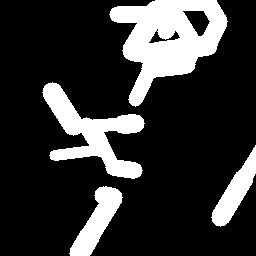

In [ ]:
msk = transforms.ToPILImage()(masks)
msk

In [ ]:
class InpaintSANet(torch.nn.Module):
    """
    Inpaint generator, input should be 5*256*256, where 3*256*256 is the masked image, 1*256*256 for mask, 1*256*256 is the guidence
    """
    def __init__(self, n_in_channel=5):
        super(InpaintSANet, self).__init__()
        cnum = 32
        self.coarse_net = nn.Sequential(
            #input is 5*256*256, but it is full convolution network, so it can be larger than 256
            GatedConv2dWithActivation(n_in_channel, cnum, 5, 1, padding=get_pad(256, 5, 1)),
            # downsample 128
            GatedConv2dWithActivation(cnum, 2*cnum, 4, 2, padding=get_pad(256, 4, 2)),
            GatedConv2dWithActivation(2*cnum, 2*cnum, 3, 1, padding=get_pad(128, 3, 1)),
            #downsample to 64
            GatedConv2dWithActivation(2*cnum, 4*cnum, 4, 2, padding=get_pad(128, 4, 2)),
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, padding=get_pad(64, 3, 1)),
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, padding=get_pad(64, 3, 1)),
            # atrous convlution
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, dilation=2, padding=get_pad(64, 3, 1, 2)),
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, dilation=4, padding=get_pad(64, 3, 1, 4)),
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, dilation=8, padding=get_pad(64, 3, 1, 8)),
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, dilation=16, padding=get_pad(64, 3, 1, 16)),
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, padding=get_pad(64, 3, 1)),
            #Self_Attn(4*cnum, 'relu'),
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, padding=get_pad(64, 3, 1)),
            # upsample
            GatedDeConv2dWithActivation(2, 4*cnum, 2*cnum, 3, 1, padding=get_pad(128, 3, 1)),
            #Self_Attn(2*cnum, 'relu'),
            GatedConv2dWithActivation(2*cnum, 2*cnum, 3, 1, padding=get_pad(128, 3, 1)),
            GatedDeConv2dWithActivation(2, 2*cnum, cnum, 3, 1, padding=get_pad(256, 3, 1)),

            GatedConv2dWithActivation(cnum, cnum//2, 3, 1, padding=get_pad(256, 3, 1)),
            #Self_Attn(cnum//2, 'relu'),
            GatedConv2dWithActivation(cnum//2, 3, 3, 1, padding=get_pad(128, 3, 1), activation=None)
        )

        self.refine_conv_net = nn.Sequential(
            # input is 5*256*256
            GatedConv2dWithActivation(n_in_channel, cnum, 5, 1, padding=get_pad(256, 5, 1)),
            # downsample
            GatedConv2dWithActivation(cnum, cnum, 4, 2, padding=get_pad(256, 4, 2)),
            GatedConv2dWithActivation(cnum, 2*cnum, 3, 1, padding=get_pad(128, 3, 1)),
            # downsample
            GatedConv2dWithActivation(2*cnum, 2*cnum, 4, 2, padding=get_pad(128, 4, 2)),
            GatedConv2dWithActivation(2*cnum, 4*cnum, 3, 1, padding=get_pad(64, 3, 1)),
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, padding=get_pad(64, 3, 1)),
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, padding=get_pad(64, 3, 1)),
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, dilation=2, padding=get_pad(64, 3, 1, 2)),
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, dilation=4, padding=get_pad(64, 3, 1, 4)),
            # Self_Attn(4*cnum, 'relu'),
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, dilation=8, padding=get_pad(64, 3, 1, 8)),

            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, dilation=16, padding=get_pad(64, 3, 1, 16))
        )
        self.refine_attn = Self_Attn(4*cnum, 'relu', with_attn=False)
        self.refine_upsample_net = nn.Sequential(
            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, padding=get_pad(64, 3, 1)),

            GatedConv2dWithActivation(4*cnum, 4*cnum, 3, 1, padding=get_pad(64, 3, 1)),
            GatedDeConv2dWithActivation(2, 4*cnum, 2*cnum, 3, 1, padding=get_pad(128, 3, 1)),
            GatedConv2dWithActivation(2*cnum, 2*cnum, 3, 1, padding=get_pad(128, 3, 1)),
            GatedDeConv2dWithActivation(2, 2*cnum, cnum, 3, 1, padding=get_pad(256, 3, 1)),

            GatedConv2dWithActivation(cnum, cnum//2, 3, 1, padding=get_pad(256, 3, 1)),
            # Self_Attn(cnum, 'relu'),
            GatedConv2dWithActivation(cnum//2, 3, 3, 1, padding=get_pad(256, 3, 1), activation=None),
        )


    def forward(self, imgs, masks, img_exs=None):
        # Coarse
        masked_imgs =  imgs * (1 - masks) + masks
        if img_exs == None:
            input_imgs = torch.cat([masked_imgs, masks, torch.full_like(masks, 1.)])
        else:
            input_imgs = torch.cat([masked_imgs, img_exs, masks, torch.full_like(masks, 1.)], dim=1)
        input_imgs = torch.reshape(input_imgs, [1, 5, 256, 256])
        x = self.coarse_net(input_imgs)
        x = torch.clamp(x, -1., 1.)
        coarse_x = x
        # Refine

        masked_imgs = imgs * (1 - masks) + coarse_x * masks
        masked_imgs = masked_imgs[0]
        if img_exs is None:
            input_imgs = torch.cat([masked_imgs, masks, torch.full_like(masks, 1.)])
        else:
            input_imgs = torch.cat([masked_imgs, img_exs, masks, torch.full_like(masks, 1.)], dim=1)
        input_imgs = torch.reshape(input_imgs, [1, 5, 256, 256])
        x = self.refine_conv_net(input_imgs)
        x = self.refine_attn(x)
        # print(x.size())
        x = self.refine_upsample_net(x)
        x = torch.clamp(x, -1., 1.)
        return coarse_x, x

In [ ]:
netG = InpaintSANet()
netD = InpaintSADirciminator()

# load_consistent_state_dict(netG_state_dict, netG)
netG.load_state_dict(netG_state_dict)

netG.eval()
netD.eval()

netG.train()
netD.train()

lr, decay = 0.0001, 0.0
optG = torch.optim.Adam(netG.parameters(), lr=lr, weight_decay=decay)
optD = torch.optim.Adam(netD.parameters(), lr=4*lr, weight_decay=decay)

def img2photo(imgs):
    return ((imgs + 1) * 127.5).transpose(1, 2).transpose(2, 3).detach().cpu().numpy()

mask = F.interpolate(masks, 256)
mask = (masks > 0).type(torch.FloatTensor)
img = F.interpolate(imgs, 256)


input = (img / 127.5 - 1)
input_img = img2photo(input.unsqueeze(0))
recon_imgs, refine = netG(input, mask)
complete_imgs = refine * mask + input * (1 - mask)



gen_img = img2photo(recon_imgs)
refine_img = img2photo(refine)
comp_img = img2photo(complete_imgs)

In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=5e4ce20ab734ff1f3dce1086ea348dd89caa897e6703264f7ec504b3a3d19aac
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
netG

InpaintSANet(
  (coarse_net): Sequential(
    (0): GatedConv2dWithActivation(
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2d): Conv2d(5, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (mask_conv2d): Conv2d(5, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (batch_norm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sigmoid): Sigmoid()
    )
    (1): GatedConv2dWithActivation(
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2d): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (mask_conv2d): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (batch_norm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sigmoid): Sigmoid()
    )
    (2): GatedConv2dWithActivation(
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2d): Conv2d(64, 64, kernel_size=(3, 3), s

In [ ]:
overlap = input * (1-mask)
print(overlap.shape)
overlap.unsqueeze(0)

I = img2photo(overlap.unsqueeze(0))
Image.fromarray(I[0].astype(np.uint8))


In [ ]:
Image.fromarray(input_img[0].astype(np.uint8))

In [ ]:
Image.open(input_image)

In [ ]:
genr_img = Image.fromarray(gen_img[0].astype(np.uint8))
genr_img

In [ ]:
ref_img = Image.fromarray(refine_img[0].astype(np.uint8))
ref_img

In [ ]:
compl_img = Image.fromarray(comp_img[0].astype(np.uint8))
compl_img

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
 
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
# images1 = randint(0, 255, 10*32*32*3)
# images1 = images1.reshape((10,32,32,3))
# images2 = randint(0, 255, 10*32*32*3)
# images2 = images2.reshape((10,32,32,3))
images1 = input_img[0]
images2 = gen_img[0]
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)